In [1]:
!pip install git+https://github.com/sylvchev/beetl-competition

  Cloning https://github.com/sylvchev/beetl-competition to /tmp/pip-req-build-vxsnhub1
  Running command git clone -q https://github.com/sylvchev/beetl-competition /tmp/pip-req-build-vxsnhub1
     |████████████████████████████████| 46 kB 1.8 MB/s 
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 6.9 MB 78.3 MB/s 
     |████████████████████████████████| 122 kB 72.5 MB/s 
     |████████████████████████████████| 28.5 MB 1.4 MB/s 
     |████████████████████████████████| 6.8 MB 67.1 MB/s 
     |████████████████████████████████| 636 kB 50.8 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 86 kB 7.4 MB/s 
  Created wheel for beetl-competition: filename=beetl_competition-0.0.0-py3-none-any.whl size=6014 sha256=2f2a09624dff1a6dcad58094b33ae15a3eb22f7679f98856807f7b2f104849c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-n5mcvi29/wheels/42/5f/6e/96b850b9ea11d43087457cdaf98b998d95ce6dbd8f240f

In [5]:
!pip install comet-ml
!pip install tensorboardX
!pip install pytorch-metric-learning[with-hooks-cpu]

     |████████████████████████████████| 124 kB 4.1 MB/s 


In [ ]:
import comet_ml

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from scipy.spatial import distance as dist
import matplotlib.pyplot as plt

import os.path as osp
import pickle
from tensorboardX import SummaryWriter
import math

from tqdm.notebook import tqdm
from pytorch_metric_learning import samplers
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
from pytorch_metric_learning import losses as loss_fn

In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sat Jul 31 10:13:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
#     # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [9]:
SEED = 123
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [10]:
from beetl.task_datasets import \
    BeetlSleepTutorial, BeetlSleepSource, BeetlSleepLeaderboard, BeetlMILeaderboard
ds = BeetlSleepSource()
path = ds.download()

MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


/usr/local/lib/python3.7/dist-packages/moabb/datasets/download.py:53: RuntimeWarning:

Setting non-standard config type: "MNE_DATASETS_BEETLSLEEPSOURCE_PATH"

100%|█████████████████████████████████████| 1.39G/1.39G [00:00<00:00, 1.21TB/s]
Unzipping contents of '/root/mne_data/MNE-beetlsleepsource-data/28567104' to '/root/mne_data/MNE-beetlsleepsource-data/28567104.unzip'


In [11]:
hyper_params = {
    "lr": 1e-3,
    "weight_decay": 1e-6,
    "scheduler_patience": 10,
    'batch_size': 256,
    'dropout_conv': 0.1,
    'dropout_fc': 0.2
}

In [13]:
from beetl.task_datasets import BeetlSleepSource
dataset = BeetlSleepSource()
from sklearn.model_selection import train_test_split
import gc

# X_train, y_train, info = dataset.get_data(subjects=range(0, 35))
# X_test, y_test, _ = dataset.get_data(subjects=range(35, 39))

X, y, _ = dataset.get_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


In [14]:
del X, y
gc.collect()

140

(72436, 2, 3000)
[[    0 19255]
 [    1  6364]
 [    2 28787]
 [    3  4181]
 [    4  2428]
 [    5 11421]]


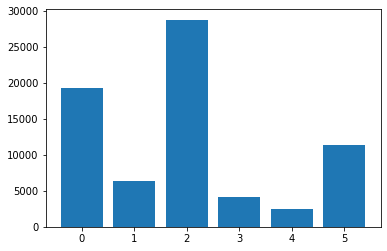

In [15]:
print(X_train.shape)
(unique, counts) = np.unique(np.asarray(y_train), return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
plt.bar(unique, counts)
plt.show()

(18109, 2, 3000)
[[   0 4788]
 [   1 1577]
 [   2 7196]
 [   3 1066]
 [   4  629]
 [   5 2853]]


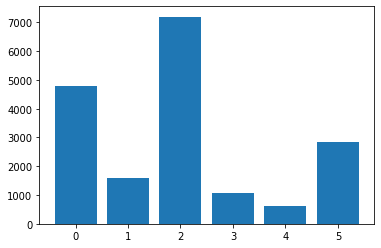

In [16]:
print(X_test.shape)
(unique, counts) = np.unique(np.asarray(y_test), return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
plt.bar(unique, counts)
plt.show()

In [17]:
from beetl.task_datasets import BeetlSleepLeaderboard
X_sleep_target, y_sleep_target, _, _ = BeetlSleepLeaderboard().get_data(subjects=range(0, 6))

/usr/local/lib/python3.7/dist-packages/moabb/datasets/download.py:53: RuntimeWarning:

Setting non-standard config type: "MNE_DATASETS_BEETLSLEEPLEADERBOARD_PATH"

100%|████████████████████████████████████████| 631M/631M [00:00<00:00, 493GB/s]
Unzipping contents of '/root/mne_data/MNE-beetlsleepleaderboard-data/28567092' to '/root/mne_data/MNE-beetlsleepleaderboard-data/28567092.unzip'


(15442, 2, 3000)


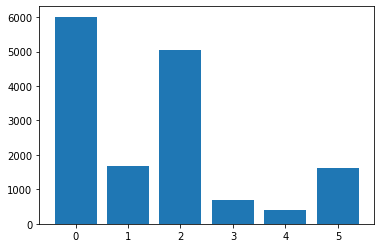

In [18]:
print(X_sleep_target.shape)
(unique, counts) = np.unique(y_sleep_target, return_counts=True)
plt.bar(unique, counts)
plt.show()

In [19]:
from torch.utils.data import DataLoader, Dataset

class EEG_data(Dataset):
    def __init__(self, train_data, train_label, mode='train'):
        mean = np.mean(train_data, axis=2, keepdims=True)
        std = np.std(train_data, axis=2, keepdims=True)
        self.X = (train_data - mean) / std
        self.X = np.transpose(self.X, (0, 2, 1))
        self.X = np.expand_dims(self.X, axis=1)
        self.y = train_label
        self.mode = mode
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        shape = self.X[0].shape
        # noise = np.random.normal(0, 0.04, 6000).reshape(shape)
        
        if self.y is not None:
            return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)
        else:
            return torch.tensor(self.X[idx], dtype=torch.float32)

In [20]:
X_train.shape

(72436, 2, 3000)

In [21]:
train_dataset = EEG_data(X_train, y_train)
test_dataset = EEG_data(X_test, y_test, mode='test')
print(train_dataset.X.shape) # should be length, 1, 3000, 2

(72436, 1, 3000, 2)


In [23]:
BATCH_SIZE = 64

In [28]:
sampler = samplers.MPerClassSampler(labels=y_train, m=BATCH_SIZE // 6, length_before_new_iter=24000)                                        

In [29]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=sampler, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [30]:
transfer_dataset = EEG_data(X_sleep_target, y_sleep_target)
transfer_loader = torch.utils.data.DataLoader(dataset=transfer_dataset, batch_size=128)

In [70]:
class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, drop_rate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, drop_rate)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, drop_rate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes,
                                out_planes,
                                i == 0 and stride or 1, drop_rate))

        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, drop_rate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)

        self.drop_rate = drop_rate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
            out = self.relu2(self.bn2(self.conv1(x)))
        else:
            out = self.relu1(self.bn1(x))
            out = self.relu2(self.bn2(self.conv1(out)))

        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)

        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor=1, drop_rate=0.5, flatten=True, stride=1):

        super(WideResNet, self).__init__()
        n_channels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]

        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(4, n_channels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, n_channels[0], n_channels[1], block, stride, drop_rate)
        # 2nd block
        self.block2 = NetworkBlock(n, n_channels[1], n_channels[2], block, 2, drop_rate)
        # 3rd block
        self.block3 = NetworkBlock(n, n_channels[2], n_channels[3], block, 2, drop_rate)

        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(n_channels[3])
        self.relu = nn.ReLU(inplace=True)
        self.nChannels = n_channels[3]
        

        if flatten:
            self.final_feat_dim = 640
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, out.size()[2:])
        out = out.view(x.size(0), -1)
        return out


In [107]:
comet_config = {
    "api_key": "",
    "project_name": "sleep-eeg",
    "workspace": "allrandom",
    "disabled": False
}

def display(tab=None):
    experiment = comet_ml.get_global_experiment()
    experiment.display(tab=tab)

writer = SummaryWriter(comet_config=comet_config)

In [126]:

    
class WvConvNet(nn.Module):
    def __init__(self, n_classes, depth, widen_factor=1, drop_rate=0.5, flatten=True, stride=1):
        super(WvConvNet, self).__init__()
        self.drop_fc = nn.Dropout(0.1)
        self.drop_conv = nn.Dropout2d(0.1)
        self.n_classes = n_classes
        self.conv_f_size = 32
        
        self.conv_fs = nn.ModuleList()
        self.bn_fs = nn.ModuleList()
        self.pool_fs = nn.ModuleList()
        for i in range(16):
            self.conv_fs.append(nn.Conv2d(in_channels=1, out_channels=self.conv_f_size, kernel_size=[5, 2], stride=1, dilation=(2*(i+1), 1)))
            self.bn_fs.append(nn.BatchNorm2d(self.conv_f_size))
            self.pool_fs.append(nn.AdaptiveAvgPool2d((32, 1)))

        n_channels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]

        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        #self.conv1 = nn.Conv2d(4, n_channels[0], kernel_size=3, stride=1,
        #                       padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, n_channels[0], n_channels[1], block, stride, drop_rate)
        # 2nd block
        self.block2 = NetworkBlock(n, n_channels[1], n_channels[2], block, 2, drop_rate)
        # 3rd block
        self.block3 = NetworkBlock(n, n_channels[2], n_channels[3], block, 2, drop_rate)

        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(n_channels[3])
        self.relu = nn.ReLU(inplace=True)
        self.nChannels = n_channels[3]

        self.linear = nn.Linear(640, n_classes)

        if flatten:
            self.final_feat_dim = 640
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    
        for conv in self.conv_fs:
            torch.nn.init.kaiming_normal_(conv.weight)

    def forward(self, x):
        outputs = []
        for i in range(len(self.conv_fs)):
            output = F.relu(self.conv_fs[i](x))
            output = self.bn_fs[i](self.pool_fs[i](output))
#             output = self.drop_conv(output)
            output = torch.squeeze(output)
            outputs.append(output)
        
        output = torch.stack((outputs), dim=1)
#         output = self.drop_conv(output)
        
        # print(output.shape)

        #out = self.conv1(output)
        out = self.block1(output)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, out.size()[2:])
        out = out.view(x.size(0), -1)

        logits = F.relu(self.linear(self.drop_fc(out)))

        return logits

In [127]:
model = WvConvNet(len(frequencies), 28, 10, drop_rate=0.5, flatten=True)

tmp_x = torch.tensor(np.random.rand(32, 1, 3000, 2).astype(np.float64))
print(tmp_x.shape)
output = model.forward(tmp_x.float())
print(output.shape)                                          

torch.Size([32, 1, 3000, 2])
torch.Size([32, 6])


In [128]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [129]:
model = model.to(device)

In [130]:
def evaluate(model, loader, confusion_matrix=False):
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0
    predicted_labels = []
    with torch.no_grad():
        for _, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            preds = torch.argmax(outputs, axis=1)
            val_total += len(labels)
            val_correct += torch.sum(labels == preds).item()
            predicted_labels.append(preds.cpu().detach().numpy())
           
            val_loss += loss_fn(outputs, labels) * len(labels)
            
    fig = None
    if confusion_matrix:
        predicted_labels = np.concatenate(predicted_labels)
        fig, ax = plot_confusion_matrix(loader.dataset.y, predicted_labels, classes=['0', '1', '2', '3', '4', '5'],
                                      normalize=True, title='Confusion matrix')
    return val_correct / val_total, val_loss / val_total, fig

In [ ]:
lr = 1e-4

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, min_lr=1e-6)

scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50], gamma=0.5)

writer.add_hparams(
    hparam_dict=hyper_params,
    metric_dict={}
)

llos = []
train_acc = []
val_accs = []
tf_accs = []
epoch = 0

while epoch < 80:
    epoch += 1
    if optimizer.state_dict()['param_groups'][0]['lr'] < 1e-5 - 1e-8:
        break
    model.train()
    print(f'Epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}')
    running_loss = 0.0
    total_loss = 0
    train_total = 0
    train_correct = 0
    with tqdm(train_loader) as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted_labels = torch.argmax(outputs, axis=1)
            train_correct += torch.sum(labels == predicted_labels).item()
            train_total += len(predicted_labels)

            # print statistics
            total_loss += loss.item() * len(labels)
            pbar.set_postfix(loss=total_loss / train_total, accuracy=(train_correct / train_total))
    mean_loss = total_loss / train_total
    llos.append(mean_loss)
    
    train_acc.append(train_correct / train_total)
    
    if epoch % 10 == 0:
        val_acc, val_loss, _= evaluate(model, test_loader, confusion_matrix=False)
        # writer.add_figure('validation confusion matrix', val_fig, epoch)
    else:
        val_acc, val_loss, _ = evaluate(model, test_loader)

    tf_acc, tf_loss, _ = evaluate(model, transfer_loader)
    print('Validation accuracy: ', val_acc)
    print('Validation loss: ', val_loss.item())
    
    print('Transfer accuracy: ', tf_acc)
    print('Transfer loss: ', tf_loss.item())

    scheduler.step()
    
    val_accs.append(val_acc)
    tf_accs.append(tf_acc)
    
    writer.add_scalars(
        'data/losses',
        {
            'train_loss': mean_loss,
            'val_loss': val_loss.item(),
            'transfer_loss': tf_loss.item(),
            
        },
        epoch,
    )

    writer.add_scalars(
        'data/accuracies',
        {
            'train_acc': train_correct / train_total,
            'val_acc': val_acc,
            'transfer_acc': tf_acc,
            
        },
        epoch,
    )
print('Finished Training')    

Epoch: 1, LR: 0.0001



Validation accuracy:  0.7617759125296814
Validation loss:  0.6092180609703064
Transfer accuracy:  0.7259422354617278
Transfer loss:  0.7039505839347839
Epoch: 2, LR: 0.0001



Validation accuracy:  0.7620520183334254
Validation loss:  0.6039992570877075
Transfer accuracy:  0.7307343608340888
Transfer loss:  0.6886084675788879
Epoch: 3, LR: 0.0001



Validation accuracy:  0.7512286708266608
Validation loss:  0.6235867738723755
Transfer accuracy:  0.7091697966584639
Transfer loss:  0.7482098937034607
Epoch: 4, LR: 0.0001



Validation accuracy:  0.7715500579822188
Validation loss:  0.5759335160255432
Transfer accuracy:  0.7344903509908043
Transfer loss:  0.6794379949569702
Epoch: 5, LR: 0.0001



Validation accuracy:  0.7650891821746093
Validation loss:  0.5921927690505981
Transfer accuracy:  0.7269136122263955
Transfer loss:  0.6878456473350525
Epoch: 6, LR: 0.0001
